# Transfer learning on graphs

In [1]:
import itertools
from multiprocessing import Pool

from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tools import *

target, graph = get_data() 

The citeseer data consists of author collaborations within the Condensed Matter research area, determined from Arxiv in 2010-2015.

## Get node embedding

In [2]:
%%time
embedding = get_embedding(graph, target=target, workers=1, quiet=False)

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:22<00:00,  8.25s/it]


CPU times: user 1min 35s, sys: 1.3 s, total: 1min 36s
Wall time: 1min 36s


Class distribution:

In [3]:
embedding['target'].value_counts()

IR        532
Agents    463
DB        388
ML        308
HCI       304
AI        115
Name: target, dtype: int64

## Train classifiers

We train the classifier in a One-Vs-Rest approach. We report the unweighted mean of the ROC-AUC of the different classes.

In [4]:
train, test = train_test_split(embedding, stratify=embedding['target'])
clf = XGBClassifier()
clf.fit(*split(train))
clf.test(*split(test))
clf.roc_auc_score

0.9059122418349537

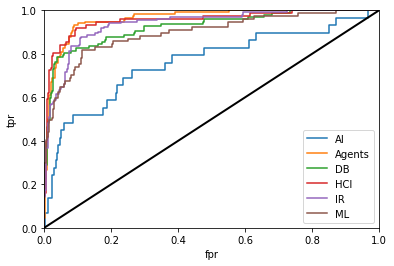

In [5]:
plot_roc_curve(clf)

## TSNE plot

Just because it is nice :) You see clustering of the different true communities.

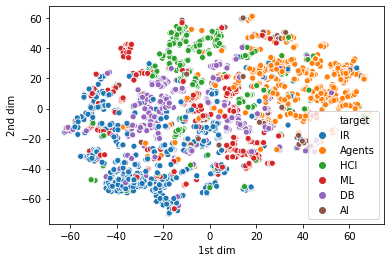

In [6]:
plot_tsne(embedding)

## Check determenistic

### Exact same embedding, check classifier
We see that `train_test_split` and `XGBClasssifier` returns same results every run (deterministic).

In [7]:
def func():
    train, test = train_test_split(embedding, stratify=embedding['target'])
    clf = XGBClassifier()
    clf.fit(*split(train))
    clf.test(*split(test))
    return clf

In [8]:
[func().roc_auc_score for _ in tqdm(range(3))]

100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


[0.9247329172078422, 0.90780723672481, 0.9045964575453463]

### Same seed in embedding and classifier
Using our [own fork of Node2Vec](https://github.com/gerritjandebruin/node2vec), we see deterministic behaviour.

In [9]:
def do_experiment():
    embedding = get_embedding(graph, target=target, quiet=True)
    train, test = train_test_split(embedding, stratify=embedding['target'])
    clf = XGBClassifier(n_jobs=12)
    clf.fit(*split(train))
    clf.test(*split(test))
    return clf

In [10]:
embedding1 = get_embedding(graph, target=target, quiet=True)

In [11]:
embedding2 = get_embedding(graph, target=target, quiet=True)

In [12]:
embedding1

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,target
brin98anatomy,1.065187,-2.109806,-3.168428,1.509939,-0.511401,-1.175388,0.750302,0.685956,0.161417,1.948912,...,-0.528746,0.641921,1.580136,-0.126117,-0.440068,0.801950,0.130404,2.747061,-1.715089,IR
rao95bdi,-0.990243,2.770993,0.257040,0.093453,-3.319110,0.867003,1.098125,0.307112,0.898441,1.258975,...,1.679979,-2.366162,4.454696,2.108659,1.352092,-0.968775,2.141410,-2.655281,-0.143803,Agents
chakrabarti98automatic,-0.336101,-1.038895,-1.329388,-0.887299,-0.644666,-0.657024,0.009551,0.934678,0.069440,1.208115,...,-0.736243,0.947622,1.675656,-0.160169,1.243615,-0.387018,-0.739756,3.027224,-3.342053,IR
bharat98improved,0.189273,-1.338905,-3.564311,-0.716558,-1.523313,-2.828936,1.313447,0.579639,1.190787,0.568059,...,1.968140,-0.735438,0.981310,-0.853955,-0.107527,-0.184648,-1.238766,3.412722,-3.424197,IR
jennings95controlling,-0.319787,2.448240,-1.561072,-1.423595,0.043787,-0.425111,2.017390,-1.716680,-0.512303,-0.451724,...,1.537051,1.050915,2.517617,2.987144,1.216939,-0.248946,-0.030704,1.521174,0.104130,Agents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524967,-0.220051,0.072351,0.521996,0.120005,-0.482142,-0.397723,0.110256,0.263137,0.542415,-0.188031,...,0.427649,-0.065099,0.025628,0.170831,0.621727,0.500980,0.509425,0.403361,-0.007734,IR
munzner95visualizing,0.087045,0.188439,-0.041863,0.277858,0.186337,-0.038298,-0.707261,0.447062,-0.075450,0.214474,...,-0.204573,0.683975,0.342872,-0.125480,0.234284,0.761895,0.139147,-0.148805,0.017461,HCI
412057,0.105458,0.072028,-0.150178,0.228382,-0.200288,-0.013562,-0.818332,0.093395,0.163476,0.613253,...,-0.090989,0.384212,0.498797,0.315754,0.150569,0.385046,0.245820,-0.110796,-0.087758,IR
460628,-0.401929,0.404044,-0.139064,-0.016024,-0.174850,0.323154,-0.160116,-0.127777,0.293511,0.128343,...,0.117953,0.168690,0.081358,-0.101313,-0.225158,0.640396,0.177108,-0.066157,0.003279,DB


In [13]:
embedding2

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,target
brin98anatomy,1.065187,-2.109806,-3.168428,1.509939,-0.511401,-1.175388,0.750302,0.685956,0.161417,1.948912,...,-0.528746,0.641921,1.580136,-0.126117,-0.440068,0.801950,0.130404,2.747061,-1.715089,IR
rao95bdi,-0.990243,2.770993,0.257040,0.093453,-3.319110,0.867003,1.098125,0.307112,0.898441,1.258975,...,1.679979,-2.366162,4.454696,2.108659,1.352092,-0.968775,2.141410,-2.655281,-0.143803,Agents
chakrabarti98automatic,-0.336101,-1.038895,-1.329388,-0.887299,-0.644666,-0.657024,0.009551,0.934678,0.069440,1.208115,...,-0.736243,0.947622,1.675656,-0.160169,1.243615,-0.387018,-0.739756,3.027224,-3.342053,IR
bharat98improved,0.189273,-1.338905,-3.564311,-0.716558,-1.523313,-2.828936,1.313447,0.579639,1.190787,0.568059,...,1.968140,-0.735438,0.981310,-0.853955,-0.107527,-0.184648,-1.238766,3.412722,-3.424197,IR
jennings95controlling,-0.319787,2.448240,-1.561072,-1.423595,0.043787,-0.425111,2.017390,-1.716680,-0.512303,-0.451724,...,1.537051,1.050915,2.517617,2.987144,1.216939,-0.248946,-0.030704,1.521174,0.104130,Agents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524967,-0.220051,0.072351,0.521996,0.120005,-0.482142,-0.397723,0.110256,0.263137,0.542415,-0.188031,...,0.427649,-0.065099,0.025628,0.170831,0.621727,0.500980,0.509425,0.403361,-0.007734,IR
munzner95visualizing,0.087045,0.188439,-0.041863,0.277858,0.186337,-0.038298,-0.707261,0.447062,-0.075450,0.214474,...,-0.204573,0.683975,0.342872,-0.125480,0.234284,0.761895,0.139147,-0.148805,0.017461,HCI
412057,0.105458,0.072028,-0.150178,0.228382,-0.200288,-0.013562,-0.818332,0.093395,0.163476,0.613253,...,-0.090989,0.384212,0.498797,0.315754,0.150569,0.385046,0.245820,-0.110796,-0.087758,IR
460628,-0.401929,0.404044,-0.139064,-0.016024,-0.174850,0.323154,-0.160116,-0.127777,0.293511,0.128343,...,0.117953,0.168690,0.081358,-0.101313,-0.225158,0.640396,0.177108,-0.066157,0.003279,DB


## Stability

In this section we vary the seed of the embedding **and** the classifier. We see only a limited variance.

In [14]:
def func(random_seed):
    embedding = get_embedding(graph, target=target, quiet=True, seed=random_seed)
    train, test = train_test_split(embedding, stratify=embedding['target'])
    clf = XGBClassifier(random_seed)
    clf.fit(*split(train))
    clf.test(*split(test))
    return clf

In [23]:
result = Parallel(n_jobs=20)(delayed(func)(i+1) for i in range(20))

In [24]:
pd.Series([clf.roc_auc_score for clf in result]).agg(['mean', 'std'])

mean    0.902420
std     0.007417
dtype: float64

## Learn model on different seed than testing

### Without any modifications

We will learn two node embeddings $\text{emb}_a$ and $\text{emb}_b$ using two different seeds. The model trained on $\text{emb}_a$ does not work on $\text{emb}_b$ for any reasonable value for $p$, $q$, $dimensions$.

In [54]:
def do_experiment(p, q, dimensions):
    embedding1 = get_embedding(graph, dimensions, p=p, q=q, target=target, quiet=True, seed=1)
    train, test = train_test_split(embedding1, stratify=embedding1['target'])
    clf = XGBClassifier(n_jobs=5)
    clf.fit(*split(train))
    clf.test(*split(test))
    same = clf.roc_auc_score
    embedding2 = get_embedding(graph, dimensions, p=p, q=q, target=target, quiet=True, seed=2)
    _, test = train_test_split(embedding2, stratify=embedding2['target'])
    clf.test(*split(test))
    diff = clf.roc_auc_score
    return dict(same=same, diff=diff, dimensions=dimensions, p=p, q=q)

In [60]:
result = ProgressParallel(n_jobs=128)(
    delayed(do_experiment)(p, q, dim) 
    for p in [1, 2, 4, 8] 
    for q in [1, 2, 4, 8] 
    for dim in [1, 2, 4, 8, 16, 32, 64]
)

In [61]:
with pd.option_context("display.max_rows", 200):
    display(pd.DataFrame(result).sort_values('diff'))

,same,diff,dimensions,p,q
92,0.654119,0.437256,2,8,2
78,0.620937,0.482517,2,4,8
22,0.632135,0.488813,2,1,8
15,0.624857,0.488893,2,1,4
50,0.670147,0.498754,2,2,8
28,0.514712,0.500000,1,2,1
35,0.527802,0.500000,1,2,2
14,0.531620,0.500000,1,1,4
98,0.494056,0.500000,1,8,4
42,0.532320,0.500000,1,2,4


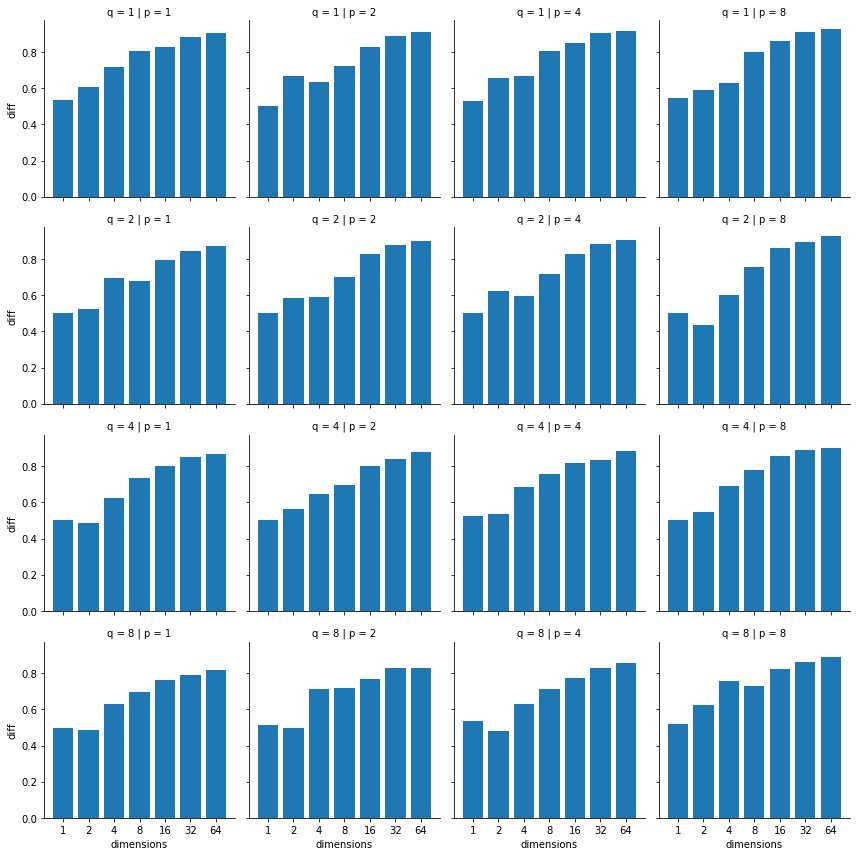

In [63]:
g = sns.FacetGrid(pd.DataFrame(result).astype({'dimensions': str}), col="p", row="q")
g.map(plt.bar, 'dimensions', 'diff')

In [65]:
pd.DataFrame(result).groupby('dimensions')['diff'].agg(['mean', 'var'])

,mean,var
dimensions,,
1,0.513037,0.000280
2,0.557124,0.004617
4,0.657853,0.002301
8,0.738701,0.001743
16,0.817940,0.001020
32,0.864240,0.001151
64,0.888125,0.001051


In [64]:
pd.DataFrame(result).groupby(['p', 'q'])['diff'].agg(['mean', 'var'])

mean       var
p q                    
1 1  0.754927  0.020217
  2  0.701275  0.021937
  4  0.696076  0.025584
  8  0.669669  0.018243
2 1  0.736466  0.022076
  2  0.711778  0.025563
  4  0.703757  0.020583
  8  0.695616  0.018879
4 1  0.762403  0.021479
  2  0.723227  0.024607
  4  0.720254  0.021006
  8  0.689838  0.020979
8 1  0.753538  0.025663
  2  0.711918  0.039470
  4  0.737967  0.026568
  8  0.744481  0.017699

### With sorting each vector

In this run, we will sort each individual vector in the embedding. Unfortunately, it does not show any gain in performance either.

In [ ]:
def order_each_vector(X: pd.DataFrame) -> pd.DataFrame:
    values = X.values
    values.sort(1)
    return pd.DataFrame(values, index=X.index)

def do_experiment(p, q, dimensions):
    random_seed = 1
    embedding1 = get_embedding(graph, dimensions, p=p, q=q, target=target, quiet=True, seed=random_seed)
    train, test = train_test_split(embedding1, stratify=embedding1['target'])
    clf = XGBClassifier(n_jobs=5)
    X, y = split(train)
    clf.fit(order_each_vector(X), y)
    X, y = split(test)
    clf.test(order_each_vector(X), y)
    same = clf.roc_auc_score
    embedding2 = get_embedding(graph, dimensions, p=p, q=q, target=target, quiet=True, seed=random_seed+1)
    _, test = train_test_split(embedding2, stratify=embedding2['target'])
    X, y = split(test)
    clf.test(order_each_vector(X), y)
    diff = clf.roc_auc_score
    return dict(same=same, diff=diff, dimensions=dimensions, p=p, q=q)

In [ ]:
it = [(p, q, dim) for p in [1, 2, 4, 8] for q in [1, 2, 4, 8] for dim in [1, 2, 4, 8, 16, 32, 64]]

In [ ]:
with Pool(processes=len(it)) as pool:
    result = pool.starmap(do_experiment, it)

In [ ]:
with pd.option_context("display.max_rows", 200):
    display(pd.DataFrame(result).sort_values('diff'))

In [ ]:
g = sns.FacetGrid(pd.DataFrame(result).astype({'dimensions': str}), col="p", row="q")
g.map(plt.bar, 'dimensions', 'diff')

In [ ]:
pd.DataFrame(result).groupby('dimensions')['diff'].agg(['mean', 'var'])

In [ ]:
pd.DataFrame(result).groupby(['p', 'q'])['diff'].agg(['mean', 'var'])

### Trying all orderings

In this run, we will try **all** (4!=24) possible orderings of the embedding. We will try only on embeddings obtained with four dimensions, since these show already good performance on the same embedding. Unfortunately, we see again poor performance.

In [66]:
def do_experiment(p, q, ordering):
    random_seed = 1
    embedding1 = get_embedding(graph, dimensions=4, p=p, q=q, target=target, quiet=True, seed=random_seed)
    train, test = train_test_split(embedding1, stratify=embedding1['target'])
    clf = XGBClassifier(n_jobs=5)
    X, y = split(train)
    clf.fit(X[ordering], y)
    X, y = split(test)
    clf.test(X[ordering], y)
    same = clf.roc_auc_score
    embedding2 = get_embedding(graph, dimensions=4, p=p, q=q, target=target, quiet=True, seed=random_seed+1)
    _, test = train_test_split(embedding2, stratify=embedding2['target'])
    X, y = split(test)
    clf.test(X[ordering], y)
    diff = clf.roc_auc_score
    return dict(same=same, diff=diff, p=p, q=q, ordering=ordering)

In [69]:
result = ProgressParallel(n_jobs=96)(
    delayed(do_experiment)(p, q, ordering) 
    for p in [1, 2, 4, 8] 
    for q in [1, 2, 4, 8] 
    for ordering in [list(combination) for combination in itertools.permutations(range(4), 4)]
)

Now we select for each $p$, $q$ the ordering of rows that yields the best performance on the test set of that $same$ embedding.

In [70]:
result_max = pd.DataFrame(result).sort_values('same', ascending=False).drop_duplicates(['p', 'q'])

In [71]:
result_max

,same,diff,p,q,ordering
125,0.852517,0.591006,2,2,"[0, 3, 2, 1]"
119,0.830886,0.642818,2,1,"[3, 2, 1, 0]"
64,0.828783,0.631824,1,4,"[2, 3, 0, 1]"
220,0.827723,0.592924,4,2,"[0, 3, 1, 2]"
7,0.826198,0.717365,1,1,"[1, 0, 3, 2]"
40,0.825426,0.687021,1,2,"[2, 3, 0, 1]"
295,0.823344,0.632617,8,1,"[1, 0, 3, 2]"
158,0.822631,0.652705,2,4,"[2, 1, 0, 3]"
377,0.821295,0.749492,8,8,"[2, 3, 1, 0]"
329,0.820475,0.606985,8,2,"[2, 3, 1, 0]"


This is for each $p$, $q$ combination the ordering of rows that yields the best performance on the test set of that $diff$ embedding. Note that we are both optimizing this test set and reporting the performance on the same set.

In [72]:
result_max = pd.DataFrame(result).sort_values('diff', ascending=False).drop_duplicates(['p', 'q'])

In [73]:
result_max

,same,diff,p,q,ordering
381,0.814169,0.760394,8,8,"[3, 1, 2, 0]"
4,0.821770,0.730086,1,1,"[0, 3, 1, 2]"
179,0.798753,0.712929,2,8,"[1, 3, 2, 0]"
39,0.821455,0.706311,1,2,"[2, 1, 3, 0]"
347,0.819045,0.700212,8,4,"[1, 3, 2, 0]"
259,0.793922,0.690232,4,4,"[3, 0, 2, 1]"
214,0.808521,0.677272,4,1,"[3, 2, 0, 1]"
149,0.818299,0.662671,2,4,"[0, 3, 2, 1]"
284,0.801285,0.657806,4,8,"[3, 1, 0, 2]"
102,0.827104,0.654076,2,1,"[1, 0, 2, 3]"


And for completeness, here the entire list:

In [74]:
with pd.option_context("display.max_rows", 999):
    display(pd.DataFrame(result).sort_values('diff', ascending=False))

,same,diff,p,q,ordering
381,0.814169,0.760394,8,8,"[3, 1, 2, 0]"
369,0.815945,0.760134,8,8,"[1, 2, 3, 0]"
361,0.812271,0.759705,8,8,"[0, 1, 3, 2]"
364,0.811798,0.759259,8,8,"[0, 3, 1, 2]"
367,0.814860,0.759221,8,8,"[1, 0, 3, 2]"
368,0.816950,0.758686,8,8,"[1, 2, 0, 3]"
363,0.811239,0.757067,8,8,"[0, 2, 3, 1]"
362,0.812937,0.756786,8,8,"[0, 2, 1, 3]"
366,0.817164,0.756649,8,8,"[1, 0, 2, 3]"
379,0.815316,0.755722,8,8,"[3, 0, 2, 1]"
